In [17]:
import imageio as iio
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as transform
import sklearn.datasets

Number of Zeros: 361107
Fraction of non-zero components: 0.5535274480712166
Threshold value: 10000.0


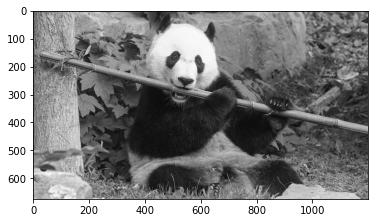

Number of Zeros: 808716
Fraction of non-zero components: 0.00010385756676557863
Threshold value: 3340000.0


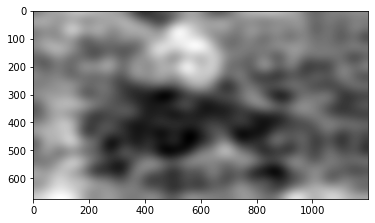

Number of Zeros: 808771
Fraction of non-zero components: 3.585558852621167e-05
Threshold value: 6670000.0


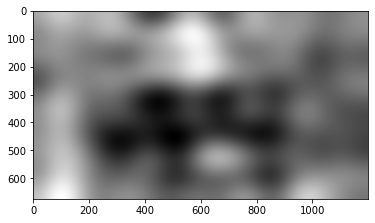

Number of Zeros: 808783
Fraction of non-zero components: 2.1018793273986153e-05
Threshold value: 10000000.0


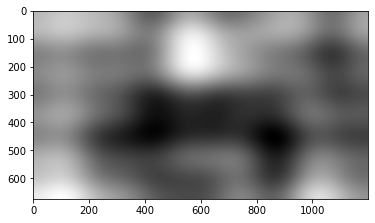

In [18]:
## Question 1 ## 

img = iio.imread("panda.png")
# generating grayscale image:
bw_img=np.sum(img,2)/3

# 2D DCT transform 
coeffs= transform.dct(transform.dct(bw_img, axis=0),axis=1)
# Set a threshold t and threshold the coefficients in coeffs which will generate
# approx_coeffs also calculate the fraction of nonzero coefficients
# Loop over different threshold values in range 10^4 - 10^7
for t in np.linspace(10**4, 10**7, 4):
    approx_coeffs = coeffs
    counter_zero = 0
    
    # Set coefficients to zero if abs(coeff) < threshold
    for idx_row, row in enumerate(approx_coeffs):
        for idx_col, coeff in enumerate(row):
            if abs(coeff) < t:
                approx_coeffs[idx_row][idx_col] = 0
                counter_zero += 1
    
    # Get fraction of non-zero components
    frac_nonzero = (coeffs.size-counter_zero)/coeffs.size
    print("Number of Zeros:", counter_zero)
    print(f"Fraction of non-zero components: {frac_nonzero}")       
    print("Threshold value:", t)
    # Apply 2d idct
    approx_img=transform.idct(transform.idct(approx_coeffs, axis=1),axis=0)

    # Plot images
    plt.imshow(approx_img, cmap='gray')
    plt.show()


In [19]:
## Question 3 ##

diabetes_data = sklearn.datasets.load_diabetes()

def soft_threshold(rho,lamda):
    
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else: 
        return 0

def obj_value(X,y,theta): # Objective value of LASSO function
    n = X.shape[1]
    
    return (1/(2*n))*(np.linalg.norm(y-X.dot(theta))**2)

    
def grad_LS(X, y, theta): # Gradient of LASSO with respect to theta
    n = X.shape[1]
    
    X_trans = X.T
    
    result = -(1 / n) * X_trans.dot(y - X.dot(theta))
    
    return result

def prox_grad(theta, X, y, alpha, max_iter, tol, lamda, optimal_value = 0):
    obj_v = 0 
    obj_values = []
    opt_gaps = []
    for i in range(max_iter):
        grad_theta = grad_LS(X, y, theta)
        prev_theta = theta.copy()
        prev_obj = obj_v
        
        for j in range(len(theta)):
            theta[j] -= alpha * grad_theta[j]
            theta[j] = soft_threshold(theta[j], lamda)
        obj_v = obj_value(X,y,theta)
        obj_values.append(obj_v)
        opt_gaps.append(obj_v - optimal_value) 
        if np.linalg.norm(prev_theta - theta) < tol:  # Convergence check
            pass
        #print("Objective Value:",obj_v,", Iteration No.",i)
        
    return theta, obj_values, i, opt_gaps

def cyclic_coord_descent(theta, X, y, alpha, max_iter, tol, lamda, optimal_value = 0):
    obj_v = 0
    obj_values = []
    opt_gaps = []
    n = X.shape[1]
    for i in range(max_iter):
        prev_theta = theta.copy()
        prev_obj = obj_v
        for j in range(n):
            r_j = y - X.dot(theta) + X[:, j].reshape(-1,1) * theta[j]  # Compute residual without considering jth feature
            theta[j] = soft_threshold(X[:, j].dot(r_j)/n, lamda) / ((X[:, j]**2).sum()/n)
        obj_v = obj_value(X,y,theta)
        obj_values.append(obj_v)
        opt_gaps.append(obj_v - optimal_value) 
        if np.linalg.norm(prev_theta - theta) < tol:
            pass
    return theta, obj_values, i, opt_gaps

def ADMM(theta, X, y, alpha, max_iter, tol, lamda, optimal_value = 0):
    XTX = X.T.dot(X)
    XTy = X.T.dot(y)
    n = X.shape[1]
    z = np.zeros(n).reshape(-1,1)
    u = np.zeros(n).reshape(-1,1)
    
    rho = 1
    opt_gaps = []
    obj_v = 0
    obj_values = []
    theta_values = []
    for i in range(max_iter):
        prev_theta = theta.copy()
        prev_obj = obj_v

        # Update theta
        theta = np.linalg.inv(XTX + rho * np.identity(n)).dot(XTy + rho * (z - u))
        
        # Update z
        for j in range(n):
            z[j] = soft_threshold(theta[j] + u[j] / rho, lamda / rho)

        # Update u
        u += theta - z
        
        obj_v = obj_value(X, y, theta)
        obj_values.append(obj_v)
        opt_gaps.append(obj_v - optimal_value) 
        theta_values.append(theta)
        if np.linalg.norm(prev_theta - theta) < tol:
            pass

    return theta, obj_values, i, theta_values, opt_gaps 

In [20]:
X = diabetes_data['data']
X = X / (np.linalg.norm(X,axis=0))
y = diabetes_data['target'].reshape((diabetes_data['target'].shape[0],1))
max_iter = 1000
lamda = 0.001
tolerance = 10**(-5)
alpha = 0.1
initial_theta = np.ones([len(X[1]),1])

------ Proximal gradient method ------
Objective Value: 575114.8524873919 , Iteration No. 999


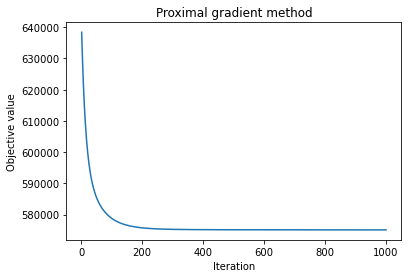

In [21]:
## Proximal gradient descent ## 

# Run the algorithm over max_iter iterations
theta, obj_values, idx, _ = prox_grad(initial_theta,X,y,alpha,max_iter,tolerance,lamda)
print("------ Proximal gradient method ------")
print("Objective Value:",obj_values[-1],", Iteration No.",idx)

# Plot result
x_plot = np.linspace(1, idx+1, idx+1)
plt.plot(x_plot, obj_values)
plt.title("Proximal gradient method")
plt.ylabel("Objective value")
plt.xlabel("Iteration")
plt.show()

------ Cyclic Coordinate Descent ------
Objective Value: 574694.8853378124 , Iteration No. 999


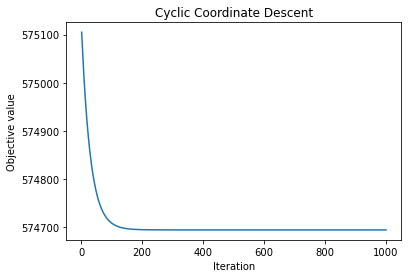

In [22]:
## Cyclic coordinate descent ## 
theta, obj_values, idx, _ = cyclic_coord_descent(initial_theta,X,y,alpha,max_iter,tolerance,lamda)
print("------ Cyclic Coordinate Descent ------")
print("Objective Value:",obj_values[-1],", Iteration No.",idx)
x_plot = np.linspace(1, idx+1, idx+1)
plt.plot(x_plot, obj_values)
plt.title("Cyclic Coordinate Descent")
plt.ylabel("Objective value")
plt.xlabel("Iteration")
plt.show()

------ ADMM ------
Objective Value: 574694.8831437211 , Iteration No. 999


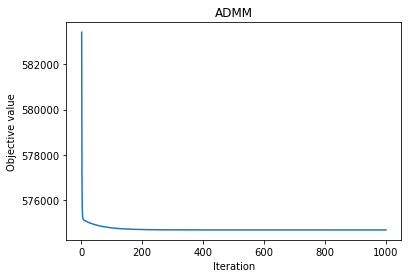

In [23]:
## ADMM ## 
theta, obj_values, idx, theta_ADMM, _ = ADMM(initial_theta,X,y,alpha,max_iter,tolerance,lamda)
print("------ ADMM ------")
print("Objective Value:",obj_values[-1],", Iteration No.",idx)
x_plot = np.linspace(1, idx+1, idx+1)
plt.plot(x_plot, obj_values)
plt.title("ADMM")
plt.ylabel("Objective value")
plt.xlabel("Iteration")
plt.show()

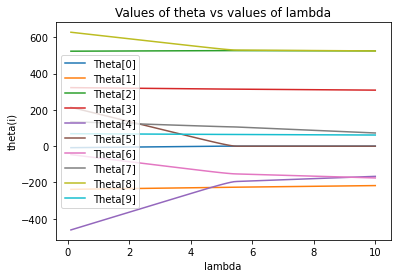

In [37]:
## Plotting values of theta over values of lambda ##
lamda = np.linspace(0.1,10,100)
theta_values = np.zeros([10,len(lamda)])
max_iter = len(lamda)

# Loop over different values of lambda
for i, l in enumerate(lamda):
    theta, obj_values, idx, theta_ADMM, opt = ADMM(initial_theta,X,y,alpha,max_iter,tolerance,l)
    
    for idx_row, value in enumerate(theta):
        theta_values[idx_row][i] = value[0]
    #print(theta_values)
            
# Plot variables over theta
for idx_theta, theta_i in enumerate(theta_values):
    plt.plot(lamda, theta_i, label = f"Theta[{idx_theta}]")
plt.title("Values of theta vs values of lambda")
plt.xlabel("lambda")
plt.ylabel("theta(i)")
plt.legend()
plt.show()

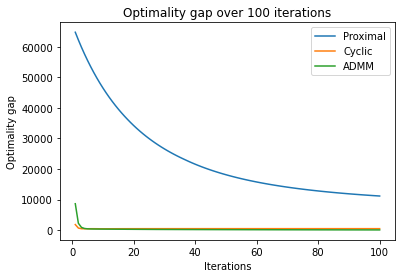

In [38]:
## plot the optimality gap vs the number of iterations ##
lamda = 2
max_iter = 10000
tolerance = 10**(-5)
alpha = 0.1
initial_theta = np.ones([len(X[1]),1])

# Get the optimal value from ADMM over many iterations
theta, obj_values, idx, theta_ADMM, _ = ADMM(initial_theta,X,y,alpha,max_iter,tolerance,lamda)
optimal_value = obj_values[-1]
max_iter = 100
iterations = np.linspace(1,100,100)

# Run the algorithms
theta, obj_values, idx, optimality_gap_prox = prox_grad(initial_theta,X,y,alpha,max_iter,tolerance,lamda,optimal_value)
theta, obj_values, idx, optimality_gap_cyclic = cyclic_coord_descent(initial_theta,X,y,alpha,max_iter,tolerance,lamda, optimal_value)
theta, obj_values, idx, theta_ADMM, optimality_gap_ADMM = ADMM(initial_theta,X,y,alpha,max_iter,tolerance,lamda, optimal_value)

# Plot the optimality gaps
plt.plot(iterations,optimality_gap_prox, label = "Proximal")
plt.plot(iterations,optimality_gap_cyclic, label = "Cyclic")
plt.plot(iterations,optimality_gap_ADMM, label = "ADMM")

plt.title("Optimality gap over 100 iterations")
plt.xlabel("Iterations")
plt.ylabel("Optimality gap")
plt.legend()
plt.show()